In [2]:
#!/usr/bin/env python3

import enum
import numpy as np
import random
from typing import Dict, Optional, Tuple, List
import torch
from torch.utils.data import Dataset

from joblib import Parallel, delayed
from tqdm.auto import tqdm
import multiprocessing

#############################
# 1) Create or refine enums #
#############################

class SimulationType(enum.Enum):
    STANDARD = "standard"


###################################################
# 2) Base Simulator & Universal Policy (no ages)  #
###################################################

class BaseSimulator:
    def __init__(self):
        self.Nh = None  # Will store total human population or relevant population size

        # Add super-spreader parameters
        self.super_spread_params = {
            'probability': 0.001,  # Probability a super-spreader emerges per infectious person
            'multiplier_shape': 4.0,  # Gamma shape
            'multiplier_scale': 1.5,  # Gamma scale
        }

        # Initialize asymptomatic parameters
        self.asymptomatic_params = None

        # Endemic parameters
        self.endemic_params = {
            'birth_rate': 0.0,
            'death_rate': 0.0,
            'importation_rate': 0.0,
            'min_R0_threshold': 1.0,
            'enable_endemic': False
        }

        # Seasonality: ALWAYS enabled for flu-like
        # We will use fewer harmonics (1 or 2), each with ~1-year period.
        num_harmonics = np.random.randint(1, 3)  # 1 or 2
        base_amp = np.random.uniform(0.2, 0.4)   # stronger amplitude typical for flu
        self._seasonal_harmonics = []

        for _ in range(num_harmonics):
            period = 365.0
            amp = base_amp * np.random.uniform(0.8, 1.2)
            # For flu, we generally see a winter peak ~day 0–60 if day 0 ~ Jan 1
            offset = np.random.uniform(0, 60)
            self._seasonal_harmonics.append((period, amp, offset))

        self._max_sim_days = 2000  # We plan to simulate ~5.5 years
        # Daily noise around 1.0 (we keep some noise for variability)
        self._daily_noise = np.random.normal(1.0, 0.05, self._max_sim_days)
        self._daily_noise = np.clip(self._daily_noise, 0.5, 2.0)

        # Keep some "peak jitters" for each year, so timing shifts ± a few weeks
        n_years = max(1, int(np.ceil(self._max_sim_days / 365.0)) + 1)
        self._annual_peak_jitter = np.random.uniform(-15.0, 15.0, size=n_years)

    def _get_seasonal_factor(self, time, amplitude, peak_day):
        """
        Returns a seasonality multiplier by summing multiple random cosines
        plus daily random noise. We clip at >= 0.0 to avoid negatives.
        """
        day_idx = int(np.floor(time))
        if day_idx < 0:
            day_idx = 0
        elif day_idx >= self._max_sim_days:
            day_idx = self._max_sim_days - 1

        # Identify which year of simulation we are in
        year_idx = int(time // 365.0)
        if year_idx >= len(self._annual_peak_jitter):
            year_idx = len(self._annual_peak_jitter) - 1

        yearly_shift = self._annual_peak_jitter[year_idx]

        val = 1.0
        for (period, amp, offset) in self._seasonal_harmonics:
            val += amp * np.cos(2.0 * np.pi * ((time - offset - yearly_shift) / period))

        noise_factor = self._daily_noise[day_idx]
        val *= noise_factor

        return max(0.0, val)

    def _randomize_asymptomatic_params(self):
        """
        Randomly generate asymptomatic parameters using some distributions.
        """
        prob = np.random.beta(3, 7)   # ~0.3 mean
        trans = np.random.beta(2, 5)  # <0.5 mean
        self.asymptomatic_params = {
            'probability': prob,
            'transmission_factor': trans
        }

    def _apply_demographic_events(self, compartments: Dict[str, float]) -> Dict[str, float]:
        """
        Apply births and deaths proportionally across compartments,
        if 'enable_endemic' is True.
        """
        if not self.endemic_params['enable_endemic']:
            return compartments

        total_pop = sum(compartments.values())
        if total_pop <= 0:
            return compartments

        # births
        births = np.random.poisson(self.endemic_params['birth_rate'] * total_pop)
        if 'S' in compartments:
            compartments['S'] += births

        # deaths
        death_rate = self.endemic_params['death_rate']
        for comp in compartments:
            current_val = compartments[comp]
            deaths = np.random.binomial(int(current_val), min(death_rate, 1.0))
            compartments[comp] = max(0, current_val - deaths)

        return compartments

    def _apply_case_importation(self, compartments: Dict[str, float]) -> Dict[str, float]:
        """
        Import new cases randomly into E or I (prefer E if it exists),
        removing them from S.
        """
        if not self.endemic_params['enable_endemic']:
            return compartments

        imports = np.random.poisson(self.endemic_params['importation_rate'])
        if imports > 0 and 'S' in compartments and compartments['S'] >= imports:
            compartments['S'] -= imports
            if 'E' in compartments and compartments['E'] is not None:
                compartments['E'] += imports
            elif 'I' in compartments and compartments['I'] is not None:
                compartments['I'] += imports

        return compartments

    def _apply_super_spreading(self, base_foi: float, num_infectious: int) -> float:
        """
        Adjust force of infection to account for potential super-spreaders.
        """
        if num_infectious <= 0:
            return base_foi

        n_super = np.random.binomial(num_infectious, self.super_spread_params['probability'])
        if n_super > 0:
            multipliers = np.random.gamma(
                shape=self.super_spread_params['multiplier_shape'],
                scale=self.super_spread_params['multiplier_scale'],
                size=n_super
            )
            regular_weight = (num_infectious - n_super) / num_infectious
            super_weight = n_super / num_infectious
            super_foi = base_foi * multipliers.mean()
            return (regular_weight * base_foi) + (super_weight * super_foi)

        return base_foi


class UniversalInterventionPolicy:
    """
    A universal policy class that can turn on/off multiple times based on daily new cases.
    By default, it can remain as in the original code, though for seasonal flu
    the chance of triggering might be lowered. We'll keep the structure mostly intact.
    """

    def __init__(self,
                 enable: bool = False,
                 on_threshold: Optional[float] = None,
                 off_threshold: Optional[float] = None,
                 trigger_delay: int = 0,
                 contact_reduction: float = 1.0,
                 water_reduction: float = 1.0,
                 vector_reduction: float = 1.0,
                 min_duration: int = 30,
                 max_duration: Optional[int] = None,
                 consecutive_off_days: int = 5
                 ):

        self.enable = enable
        self.on_threshold = on_threshold
        self.off_threshold = off_threshold
        self.trigger_delay = trigger_delay

        self.contact_reduction = contact_reduction
        self.water_reduction = water_reduction
        self.vector_reduction = vector_reduction

        self.min_duration = min_duration
        self.max_duration = max_duration

        self.consecutive_below_count = 0
        self.consecutive_off_days = consecutive_off_days

        self.active = False
        self.intervention_start = None
        self.scheduled_on_day = None
        self.enable_day = None

    def get_factors(self, day: int, daily_new_cases: List[float]) -> Dict[str, float]:
        """
        Returns {'contact': X, 'water': Y, 'vector': Z} for day.
        If enable=False, always return 1.0 for each factor.
        Otherwise, check daily_new_cases to manage on/off state.
        """
        if not self.enable:
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        current_cases = daily_new_cases[day] if day < len(daily_new_cases) else 0

        if not self.active:
            if self.enable_day is not None:
                # We are waiting for scheduled turn-on day
                if day >= self.enable_day:
                    self.active = True
                    self.intervention_start = day
                    self.consecutive_below_count = 0
                    self.enable_day = None
            else:
                # Check threshold crossing
                if (self.on_threshold is not None) and (current_cases >= self.on_threshold):
                    self.scheduled_on_day = day
                    self.enable_day = day + self.trigger_delay

            if not self.active:
                return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        # If we ARE active
        days_active = day - (self.intervention_start if self.intervention_start is not None else day)
        if days_active < self.min_duration:
            return {
                'contact': self.contact_reduction,
                'water': self.water_reduction,
                'vector': self.vector_reduction
            }

        if (self.max_duration is not None) and (days_active >= self.max_duration):
            # Force off
            self.active = False
            self.intervention_start = None
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        if (self.off_threshold is not None) and (current_cases < self.off_threshold):
            self.consecutive_below_count += 1
        else:
            self.consecutive_below_count = 0

        if self.consecutive_below_count >= self.consecutive_off_days:
            self.active = False
            self.intervention_start = None
            self.consecutive_below_count = 0
            return {'contact': 1.0, 'water': 1.0, 'vector': 1.0}

        return {
            'contact': self.contact_reduction,
            'water': self.water_reduction,
            'vector': self.vector_reduction
        }


############################################################
# 3) HumanToHumanSimulator (single population, no ages)    #
############################################################

class HumanToHumanSimulator(BaseSimulator):
    def __init__(self):
        super().__init__()

    def simulate(self,
                 population_size: int,
                 beta: float,
                 gamma: float,
                 has_latent: bool = False,
                 has_waning: bool = False,
                 has_asymptomatic: bool = False,
                 sigma: Optional[float] = None,
                 omega: Optional[float] = None,
                 seasonal_amplitude: float = 0.0,
                 seasonal_peak: float = 0.0,
                 simulation_type: SimulationType = SimulationType.STANDARD,
                 num_days: int = 2000,  # forced to 2000 for multi-year flu
                 tau: float = 0.1,
                 random_seed: Optional[int] = None,
                 enable_endemic: bool = False,
                 birth_rate: float = 0.0,
                 death_rate: float = 0.0,
                 importation_rate: float = 0.0,
                 multiple_waves: bool = True,
                 wave_change_days: Optional[List[int]] = None,
                 wave_betas: Optional[List[float]] = None
                 ) -> Tuple[List[int], bool]:
        """
        S-E-I-(A)-R single-population simulation with forced seasonality and wave changes.
        We fix num_days=2000 to capture multiple years of "flu."
        """

        if random_seed is not None:
            np.random.seed(random_seed)
            random.seed(random_seed)

        if has_latent and sigma is None:
            raise ValueError("sigma must be provided if has_latent=True")
        if has_waning and omega is None:
            raise ValueError("omega must be provided if has_waning=True")

        if has_asymptomatic:
            self._randomize_asymptomatic_params()
        else:
            self.asymptomatic_params = None

        self.endemic_params['enable_endemic'] = enable_endemic
        self.endemic_params['birth_rate'] = birth_rate
        self.endemic_params['death_rate'] = death_rate
        self.endemic_params['importation_rate'] = importation_rate

        self.Nh = max(population_size, 1)

        # Helper for stepwise beta changes:
        def get_beta_for_day(day: int) -> float:
            if not multiple_waves or not wave_change_days or not wave_betas:
                return beta
            for i, change_day in enumerate(wave_change_days):
                if day < change_day:
                    return wave_betas[i]
            return wave_betas[-1]

        # Decide if novel outbreak
        is_novel = np.random.random() < 0.99
        if is_novel:
            Sh = self.Nh
            Rh = 0
            initial_cases = np.random.negative_binomial(n=5, p=0.5)
        else:
            immune_frac = np.random.uniform(0.2, 0.8)
            Rh = int(immune_frac * self.Nh)
            Sh = self.Nh - Rh
            initial_cases = np.random.negative_binomial(n=20, p=0.5)

        initial_cases = min(initial_cases, Sh)
        Sh -= initial_cases

        if has_latent:
            Eh = initial_cases
            Ih = 0
            Ah = 0 if has_asymptomatic else None
        else:
            if has_asymptomatic:
                n_asymp = np.random.binomial(initial_cases, self.asymptomatic_params['probability'])
                Ah = n_asymp
                Ih = initial_cases - n_asymp
            else:
                Ih = initial_cases
                Ah = None
            Eh = 0

        daily_new_cases = [Ih + (Ah if has_asymptomatic else 0)]

        # Potential intervention logic - for typical flu we might reduce
        # the chance of big interventions. Let's keep a small chance.
        intervention_enabled = (np.random.rand() < 0.1)  # 10% chance
        if intervention_enabled:
            fraction = np.random.uniform(0.00001, 0.0005)
            trigger_threshold = fraction * population_size
            off_threshold = trigger_threshold * np.random.uniform(0.0, 1.0)
            consecutive_days = np.random.randint(1, 50)
            trigger_delay = np.random.randint(0, 21)
            reduction_factor = np.random.uniform(0.2, 0.6)
            min_duration = np.random.randint(14, 35)
            max_duration = np.random.randint(60, 120) if (np.random.rand() < 0.5) else None

            policy = UniversalInterventionPolicy(
                enable=True,
                on_threshold=trigger_threshold,
                off_threshold=off_threshold,
                trigger_delay=trigger_delay,
                contact_reduction=reduction_factor,
                min_duration=min_duration,
                max_duration=max_duration,
                consecutive_off_days=consecutive_days
            )
        else:
            policy = UniversalInterventionPolicy(enable=False)

        # Discrete daily simulation
        for day in range(num_days - 1):
            sf = self._get_seasonal_factor(day, seasonal_amplitude, seasonal_peak)
            factors = policy.get_factors(day, daily_new_cases)

            wave_beta = get_beta_for_day(day)
            daily_beta = wave_beta * factors['contact']

            # Demographic updates
            compartments = {
                'S': Sh,
                'E': Eh if has_latent else 0,
                'I': Ih,
                'A': Ah if has_asymptomatic else 0,
                'R': Rh
            }
            compartments = self._apply_demographic_events(compartments)
            compartments = self._apply_case_importation(compartments)
            Sh = compartments['S']
            if has_latent:
                Eh = compartments['E']
            Ih = compartments['I']
            if has_asymptomatic:
                Ah = compartments['A']
            Rh = compartments['R']

            total_infectious = Ih
            if has_asymptomatic:
                total_infectious += Ah * self.asymptomatic_params['transmission_factor']

            foi = daily_beta * sf * (total_infectious / max(1, Sh + Eh + Ih + (Ah if Ah else 0) + Rh))
            foi = self._apply_super_spreading(foi, int(total_infectious))

            p_inf = 1 - np.exp(-foi)
            p_inf = np.clip(p_inf, 0.0, 1.0)
            new_exposures = np.random.binomial(Sh, p_inf)

            # Split asymptomatic if present
            if has_asymptomatic:
                p_asymp = self.asymptomatic_params['probability']
                new_asymp = np.random.binomial(new_exposures, p_asymp)
                new_symp = new_exposures - new_asymp
            else:
                new_asymp = 0
                new_symp = new_exposures

            if has_latent:
                p_prog = 1 - np.exp(-sigma)
                p_prog = np.clip(p_prog, 0.0, 1.0)
                new_infections = np.random.binomial(Eh, p_prog)
            else:
                new_infections = new_symp

            p_rec = 1 - np.exp(-gamma)
            p_rec = np.clip(p_rec, 0.0, 1.0)
            recs = np.random.binomial(Ih, p_rec)
            asymp_recs = 0
            if has_asymptomatic:
                asymp_recs = np.random.binomial(Ah, p_rec)

            wan = 0
            if has_waning:
                p_wan = 1 - np.exp(-omega)
                p_wan = np.clip(p_wan, 0.0, 1.0)
                wan = np.random.binomial(Rh, p_wan)

            # Update compartments
            Sh = max(0, Sh - new_symp - new_asymp + wan)
            if has_latent:
                Eh = max(0, Eh + new_symp - new_infections)
            Ih = max(0, Ih + (new_infections if has_latent else new_symp) - recs)
            if has_asymptomatic:
                Ah = max(0, Ah + new_asymp - asymp_recs)
            Rh = max(0, Rh + recs + asymp_recs - wan)

            daily_new_cases.append(new_infections if has_latent else new_symp)

        while len(daily_new_cases) < num_days:
            daily_new_cases.append(0)

        return daily_new_cases, intervention_enabled


###########################################
# 6) Post-processing (Hospital/Death)     #
###########################################

def enforce_no_post_outbreak_cases(true_cases, reported_cases):
    """
    Force reported_cases to be zero after the final day that true_cases are nonzero.
    """
    true_arr = np.array(true_cases, dtype=float)
    rep_arr = np.array(reported_cases, dtype=float)

    nonzero_indices = np.where(true_arr > 0)[0]
    if len(nonzero_indices) == 0:
        return rep_arr

    last_nonzero_day = nonzero_indices[-1]
    rep_arr[last_nonzero_day+1:] = 0.0
    return rep_arr

def generate_hospitalizations_and_deaths(
    daily_cases: List[int],
    num_days: int,
    hosp_prob: float,
    death_prob_hosp: float,
    hosp_lag_shape: float,
    hosp_lag_scale: float,
    death_lag_shape: float,
    death_lag_scale: float
) -> Tuple[List[int], List[int]]:
    """
    Given daily SYMPTOMATIC new infections, generate daily new hospitalizations and new deaths.
    """
    daily_hosp = [0]*num_days
    daily_death = [0]*num_days

    for day in range(num_days):
        infections_today = daily_cases[day]
        if infections_today <= 0:
            continue

        n_hosp = np.random.binomial(infections_today, hosp_prob)

        if n_hosp > 0:
            lags_h = np.random.gamma(hosp_lag_shape, hosp_lag_scale, size=n_hosp)
            lags_h_rounded = np.round(lags_h).astype(int)
            for i in range(n_hosp):
                hosp_day = day + lags_h_rounded[i]
                if 0 <= hosp_day < num_days:
                    daily_hosp[hosp_day] += 1

            n_die = np.random.binomial(n_hosp, death_prob_hosp)
            if n_die > 0:
                lags_d = np.random.gamma(death_lag_shape, death_lag_scale, size=n_die)
                lags_d_rounded = np.round(lags_d).astype(int)
                # Match each death to a distinct hospitalized index
                death_indices = np.random.choice(n_hosp, size=n_die, replace=False)
                for j in range(n_die):
                    hosp_index = death_indices[j]
                    hosp_day = day + lags_h_rounded[hosp_index]
                    death_day = hosp_day + lags_d_rounded[j]
                    if 0 <= death_day < num_days:
                        daily_death[death_day] += 1

    return daily_hosp, daily_death


def add_smaller_reporting_noise(values: List[int]) -> Tuple[List[int], dict]:
    """
    Add smaller/less dramatic reporting noise for hospitalizations/deaths.
    """
    arr = np.array(values, dtype=float).copy()
    rep_params = {}

    apply_reporting_rate = (random.random() < 0.7)
    if apply_reporting_rate:
        initial_rate = random.uniform(0.6, 0.8)
        final_rate = random.uniform(0.85, 0.98)
        days_to_max = random.randint(30, 200)
        length = len(arr)
        x = np.arange(length)
        midpoint = days_to_max / 2.0
        steepness = random.uniform(3, 6)
        base_rates = initial_rate + (final_rate - initial_rate) * (
            1/(1 + np.exp(-steepness*((x-midpoint)/days_to_max)))
        )
        base_rates = np.clip(base_rates, 0.0, 1.0)

        new_vals = []
        for i in range(length):
            new_vals.append(np.random.binomial(int(arr[i]), base_rates[i]))
        arr = np.array(new_vals)

        rep_params['reporting_rate'] = {
            'apply': True,
            'initial_rate': initial_rate,
            'final_rate': final_rate,
            'days_to_max': days_to_max
        }
    else:
        rep_params['reporting_rate'] = {'apply': False}

    apply_weekday = (random.random() < 0.4)
    if apply_weekday:
        offset = random.randint(0,6)
        for day_i in range(len(arr)):
            wd = (day_i + offset) % 7
            factor = 1.0
            if wd == 5:  # Saturday
                factor = random.uniform(0.85, 0.95)
            elif wd == 6:  # Sunday
                factor = random.uniform(0.80, 0.90)
            arr[day_i] *= factor

        rep_params['weekday_effect'] = True
    else:
        rep_params['weekday_effect'] = False

    arr = np.round(np.clip(arr, 0, None)).astype(int)
    return arr.tolist(), rep_params


###########################################
# 7) Data Generation & Dataset builder    #
###########################################

def add_noise(cases):
    """
    Add overdispersion-like noise and mild multiplicative noise to daily cases.
    """
    noise_params = {}
    arr = np.array(cases, dtype=float).copy()

    # Overdispersion
    r = 1200
    noise_params['overdispersion'] = {'r': r}

    # Multiplicative lognormal
    nf = np.random.lognormal(mean=0, sigma=0.1, size=len(arr))
    arr *= nf
    arr = np.maximum(0, arr)
    arr[cases == 0] = 0
    noise_params['multiplicative_noise'] = {'sigma': 0.1}

    return np.round(arr).astype(int).tolist(), noise_params


def add_reporting_effects(true_cases):
    """
    Add possible underreporting, weekday pattern, lab noise, and delays.
    """
    cases = np.array(true_cases, dtype=float).copy()
    reporting_params = {}
    apply_reporting_rate = (random.random() < 0.8)
    apply_weekday = (random.random() < 0.8)
    apply_lab_noise = (random.random() < 0.8)
    apply_delays = (random.random() < 0.8)
    apply_batch = (random.random() < 0.0)  # turned off

    reporting_params['has_underreporting'] = apply_reporting_rate
    reporting_params['effects_applied'] = {
        'reporting_rate': apply_reporting_rate,
        'weekday': apply_weekday,
        'lab_noise': apply_lab_noise,
        'delays': apply_delays,
        'batch': apply_batch
    }

    try:
        if apply_reporting_rate or apply_delays:
            days_to_max_testing = random.randint(30, 365)
            outbreak_start_day = random.choices(
                population=range(0, 31),
                weights=[1, 1, 1, 10, 10, 10, 10, 10, 5, 5, 5] + [1]*20,
                k=1
            )[0]

            sequence_days = np.arange(len(cases))
            absolute_days = sequence_days + outbreak_start_day
            progress = np.clip(absolute_days / days_to_max_testing, 0, 1)

            midpoint = 0.5
            steepness = random.uniform(4, 8)

            reporting_params['testing_improvement'] = {
                'days_to_max_testing': days_to_max_testing,
                'outbreak_start_day': outbreak_start_day,
                'sequence_start_day': outbreak_start_day,
                'sequence_end_day': outbreak_start_day + len(cases) - 1,
                'midpoint': midpoint,
                'steepness': steepness
            }

        if apply_reporting_rate:
            initial_rate = random.uniform(0.05, 0.4)
            final_rate = random.uniform(0.25, 0.85)

            base_rates = initial_rate + (final_rate - initial_rate)*(
                1 / (1 + np.exp(-steepness*(progress - midpoint)))
            )
            noise_vec = np.random.normal(0, 0.05, len(cases))
            rate_vec = np.clip(base_rates + noise_vec, 0.1, 0.98)

            int_cases = cases.astype(int)
            new_cases = []
            for i in range(len(int_cases)):
                new_cases.append(np.random.binomial(int_cases[i], rate_vec[i]))
            cases = np.array(new_cases, dtype=float)
            reporting_params['reporting_rate'] = {
                'initial_rate': initial_rate,
                'final_rate': final_rate
            }

        if apply_weekday:
            weekday_effects = {
                'monday':    {'mean':1.2, 'std':0.15},
                'tuesday':   {'mean':1.0, 'std':0.1 },
                'wednesday': {'mean':1.0, 'std':0.1 },
                'thursday':  {'mean':1.0, 'std':0.1 },
                'friday':    {'mean':0.9, 'std':0.12},
                'saturday':  {'mean':0.6, 'std':0.2 },
                'sunday':    {'mean':0.4, 'std':0.2 }
            }
            offset = random.randint(0,6)
            wpattern = np.ones_like(cases)
            for day_i in range(len(cases)):
                wd = (day_i + offset) % 7
                if wd == 0:
                    eff = weekday_effects['monday']
                elif wd == 5:
                    eff = weekday_effects['saturday']
                elif wd == 6:
                    eff = weekday_effects['sunday']
                elif wd == 4:
                    eff = weekday_effects['friday']
                else:
                    eff = weekday_effects['tuesday']
                val = np.random.normal(eff['mean'], eff['std'])
                wpattern[day_i] = max(0.1, min(val, 2.0))
            cases = cases * wpattern
            reporting_params['weekday_pattern'] = wpattern.tolist()

        if apply_lab_noise:
            lab_batch_size = np.random.poisson(100)
            num_batches = len(cases)//lab_batch_size + 1
            lab_acc = np.random.normal(1.0, 0.08, size=num_batches)
            bad_batch_mask = np.random.random(size=num_batches) < 0.005
            lab_acc[bad_batch_mask] = np.random.uniform(0.7, 0.85, size=np.sum(bad_batch_mask))

            daily_load = cases / (np.percentile(cases, 90) + 1e-10)
            load_penalty = np.exp(-0.2 * np.maximum(0, daily_load - 0.8))

            lab_noise = np.ones_like(cases)
            for b_i in range(num_batches):
                start_idx = b_i*lab_batch_size
                end_idx = min((b_i+1)*lab_batch_size, len(cases))
                lab_noise[start_idx:end_idx] = lab_acc[b_i] * load_penalty[start_idx:end_idx]

            cases *= lab_noise
            reporting_params['lab_noise'] = {
                'batch_size': lab_batch_size,
                'mean_accuracy': 1.0,
                'accuracy_std': 0.08,
                'bad_batch_rate': 0.005
            }

        if apply_delays:
            initial_max_delay = random.randint(7, 21)
            final_max_delay = random.randint(2, 7)
            delayed_arr = np.zeros_like(cases)

            alpha_init = 1.0
            alpha_final = 4.0

            for t in range(len(cases)):
                p = progress[t]
                current_max_delay = int(
                    initial_max_delay + (final_max_delay - initial_max_delay) *
                    (1 / (1 + np.exp(-steepness*(p - midpoint))))
                )
                current_alpha = alpha_init + (alpha_final - alpha_init)*p

                delay_weights = np.array([current_alpha/(i+1) for i in range(current_max_delay)])
                delay_dist = delay_weights / delay_weights.sum()

                for d, prob in enumerate(delay_dist):
                    if (t + d) < len(delayed_arr):
                        delayed_arr[t + d] += cases[t] * prob

            cases = delayed_arr
            reporting_params['delay_distribution'] = {
                'initial_max_delay': initial_max_delay,
                'final_max_delay': final_max_delay,
                'alpha_initial': alpha_init,
                'alpha_final': alpha_final
            }

        if apply_batch:
            reporting_params['batch_effect'] = True
        else:
            reporting_params['batch_effect'] = False

        cases = np.maximum(0, cases)
        return np.round(cases).astype(int).tolist(), reporting_params

    except Exception as e:
        return true_cases, {'error': str(e)}


def generate_batch(args):
    """
    Standalone function for generating a batch of samples with the new flu-like logic:
      - 2000-day simulation
      - Always multiple waves
      - Each year: at least one wave change in late summer, optional second wave in winter/spring
      - Lower hospitalization probabilities and shorter delays
    """
    start_idx, size, seed = args

    # We'll only use HumanToHumanSimulator here for a "flu-like" disease,
    # but keep the dictionary structure for continuity.
    simulators = {
        'human': HumanToHumanSimulator()
    }

    def build_flu_wave_schedule(num_days=2000) -> Tuple[List[int], List[float]]:
        """
        For ~5 years, each year we add at least one wave-change day,
        with a 25-30% chance of a second wave change in the same year.
        Each wave gets a random beta in [0.15..0.35].
        """
        wave_change_days = []
        wave_betas = []

        # We'll define an initial wave beta that applies from day=0 until the first wave change
        # (in first year).
        current_betas = [random.uniform(0.15, 0.35)]

        n_years = int(np.ceil(num_days / 365))
        for y in range(n_years):
            # Primary wave-change day in late summer
            primary_day = y*365 + np.random.randint(180, 240)
            if primary_day < num_days:
                wave_change_days.append(primary_day)
                current_betas.append(random.uniform(0.15, 0.35))

            # 25% chance of second wave in same year
            if random.random() < 0.25:
                # Place second wave in winter/early spring, e.g. day 280..350 of the same year
                second_day = y*365 + np.random.randint(280, 360)
                if second_day < num_days:
                    wave_change_days.append(second_day)
                    current_betas.append(random.uniform(0.15, 0.35))

        # Sort wave_change_days to ensure they go in ascending order
        wave_sort_idx = np.argsort(wave_change_days)
        wave_change_days = [wave_change_days[i] for i in wave_sort_idx]
        wave_betas = [current_betas[0]]
        for i in wave_sort_idx:
            wave_betas.append(current_betas[i+1])

        return wave_change_days, wave_betas

    samples = []
    for i in range(size):
        idx = start_idx + i
        random.seed(seed + idx)
        np.random.seed(seed + idx)

        max_attempts = 50
        attempt = 0
        success = False

        while attempt < max_attempts and not success:
            try:
                sim_type = 'human'
                simulator = simulators[sim_type]

                population_size = int(np.exp(np.random.uniform(np.log(50_000), np.log(4_000_000))))
                has_latent = (random.random() < 0.5)
                has_waning = (random.random() < 1.0)
                has_asymptomatic = (random.random() < 0.6)
                enable_endemic = (random.random() < 1.0)

                # We fix seasonality to be "on" for flu-like
                seasonal_amplitude = 0.2  # Not used directly in _get_seasonal_factor, but we keep it for signature
                seasonal_peak = 0.0

                if enable_endemic:
                    birth_rate = random.uniform(0.00004, 0.00012)
                    death_factor = random.uniform(0.8, 1.2)
                    death_rate = birth_rate * death_factor
                    log_import = random.uniform(np.log(0.05), np.log(0.3))
                    importation_rate = np.exp(log_import)
                else:
                    birth_rate = 0.0
                    death_rate = 0.0
                    importation_rate = 0.0

                sigma = random.uniform(0.2, 0.33) if has_latent else None
                omega = random.uniform(0.002, 0.025) if has_waning else None
                sim_type_enum = SimulationType.STANDARD

                # We'll define gamma typical for flu
                gamma = random.uniform(1/7, 1/4)  # faster recovery than some COVID param

                # We'll define the "base" beta only as a fallback if multiple_waves fails,
                # but we actually rely on wave_betas below.
                base_beta = random.uniform(0.15, 0.35)
                wave_days, wave_betas = build_flu_wave_schedule(num_days=2000)

                # Now simulate 2000 days
                daily_new, intervention_enabled = simulator.simulate(
                    population_size=population_size,
                    beta=base_beta,
                    gamma=gamma,
                    has_latent=has_latent,
                    has_waning=has_waning,
                    has_asymptomatic=has_asymptomatic,
                    sigma=sigma,
                    omega=omega,
                    seasonal_amplitude=seasonal_amplitude,
                    seasonal_peak=seasonal_peak,
                    simulation_type=sim_type_enum,
                    num_days=2000,
                    enable_endemic=enable_endemic,
                    birth_rate=birth_rate,
                    death_rate=death_rate,
                    importation_rate=importation_rate,
                    multiple_waves=True,  # forced
                    wave_change_days=wave_days,
                    wave_betas=wave_betas
                )

                daily_sum = sum(daily_new)
                if daily_sum < 10 or any(x < 0 for x in daily_new):
                    raise ValueError(f"Invalid daily cases: sum={daily_sum}")

                # 1) Add noise to daily new cases
                noisy, noise_params = add_noise(daily_new)

                # 2) Add reporting effects
                reported, report_params = add_reporting_effects(noisy)
                reported = enforce_no_post_outbreak_cases(daily_new, reported)

                if not all(x >= 0 for x in reported):
                    raise ValueError("Negative reported values found.")
                if sum(reported) < 150 or max(reported) < 10:
                    raise ValueError("Too few reported cases after noise/reporting effects.")

                if has_asymptomatic and simulator.asymptomatic_params is not None:
                    asymp_p = simulator.asymptomatic_params['probability']
                    daily_symp = [np.random.binomial(dn, 1.0 - asymp_p) for dn in daily_new]
                else:
                    daily_symp = daily_new

                # 3) Generate hospitalizations & deaths with lower prob and shorter lags
                hosp_prob = random.uniform(0.05, 0.1)
                death_prob_hosp = random.uniform(0.15, 0.2)
                hosp_lag_shape = random.uniform(2.0, 3.0)
                hosp_lag_scale = random.uniform(1.0, 2.0)
                death_lag_shape = random.uniform(1.5, 2.0)
                death_lag_scale = random.uniform(2.0, 3.0)

                daily_hosp_true, daily_death_true = generate_hospitalizations_and_deaths(
                    daily_cases=daily_symp,
                    num_days=2000,
                    hosp_prob=hosp_prob,
                    death_prob_hosp=death_prob_hosp,
                    hosp_lag_shape=hosp_lag_shape,
                    hosp_lag_scale=hosp_lag_scale,
                    death_lag_shape=death_lag_shape,
                    death_lag_scale=death_lag_scale
                )

                # 4) Add smaller reporting noise
                daily_hosp_reported, hosp_rep_params = add_smaller_reporting_noise(daily_hosp_true)
                daily_death_reported, death_rep_params = add_smaller_reporting_noise(daily_death_true)

                daily_hosp_reported = enforce_no_post_outbreak_cases(daily_hosp_true, daily_hosp_reported).tolist()
                daily_death_reported = enforce_no_post_outbreak_cases(daily_death_true, daily_death_reported).tolist()

                # Convert to torch tensors
                true_data_t = torch.tensor(daily_new, dtype=torch.float32)
                report_data_t = torch.tensor(reported, dtype=torch.float32)
                hosp_true_t = torch.tensor(daily_hosp_true, dtype=torch.float32)
                hosp_rep_t = torch.tensor(daily_hosp_reported, dtype=torch.float32)
                death_true_t = torch.tensor(daily_death_true, dtype=torch.float32)
                death_rep_t = torch.tensor(daily_death_reported, dtype=torch.float32)

                disease_chars = {
                    'is_waterborne': False,
                    'is_vectorborne': False,
                    'has_latent_period': has_latent,
                    'has_waning_immunity': has_waning,
                    'has_seasonality': True,
                    'has_asymptomatic': has_asymptomatic,
                    'intervention_enabled': intervention_enabled,
                    'underreporting': report_params.get('has_underreporting', False)
                }

                disease_chars_t = torch.tensor([
                    float(disease_chars['is_waterborne']),
                    float(disease_chars['is_vectorborne']),
                    float(disease_chars['has_latent_period']),
                    float(disease_chars['has_waning_immunity']),
                    float(disease_chars['has_seasonality']),
                    float(disease_chars['has_asymptomatic']),
                    float(disease_chars['intervention_enabled']),
                    float(disease_chars['underreporting'])
                ], dtype=torch.float32)

                if (torch.isnan(true_data_t).any() or
                    torch.isnan(report_data_t).any() or
                    torch.isnan(disease_chars_t).any() or
                    torch.isnan(hosp_true_t).any() or
                    torch.isnan(hosp_rep_t).any() or
                    torch.isnan(death_true_t).any() or
                    torch.isnan(death_rep_t).any()):
                    raise ValueError("NaN detected in tensors.")

                generation_params = {
                    'simulation': {
                        'population_size': population_size,
                        'beta': base_beta,
                        'gamma': gamma,
                        'has_latent': has_latent,
                        'has_waning': has_waning,
                        'has_asymptomatic': has_asymptomatic,
                        'sigma': sigma,
                        'omega': omega,
                        'seasonal_amplitude': seasonal_amplitude,
                        'seasonal_peak': seasonal_peak,
                        'simulation_type': str(sim_type_enum),
                        'num_days': 2000,
                        'enable_endemic': enable_endemic,
                        'birth_rate': birth_rate,
                        'death_rate': death_rate,
                        'importation_rate': importation_rate,
                        'multiple_waves': True,
                        'wave_change_days': wave_days,
                        'wave_betas': wave_betas
                    },
                    'noise': noise_params,
                    'reporting': report_params,
                    'hospital_death': {
                        'hosp_prob': hosp_prob,
                        'death_prob_hosp': death_prob_hosp,
                        'hosp_lag_shape': hosp_lag_shape,
                        'hosp_lag_scale': hosp_lag_scale,
                        'death_lag_shape': death_lag_shape,
                        'death_lag_scale': death_lag_scale,
                        'hosp_reporting': hosp_rep_params,
                        'death_reporting': death_rep_params
                    }
                }

                samples.append((
                    true_data_t,
                    report_data_t,
                    hosp_true_t,
                    hosp_rep_t,
                    death_true_t,
                    death_rep_t,
                    sim_type,
                    generation_params,
                    disease_chars_t
                ))
                success = True

            except Exception:
                pass

            attempt += 1

    return samples


class DiseaseSimulationDataset(Dataset):
    """
    A dataset that generates large-scale disease simulations for ~2000 days,
    modeling a flu-like multi-year scenario with annual wave changes,
    seasonality, etc.
    """
    def __init__(self, num_samples=3000, seed=42, num_workers=4, batch_size=1000):
        super().__init__()
        self.num_samples = num_samples
        self.seed = seed
        self.num_workers = min(num_workers, multiprocessing.cpu_count() - 1)
        self.batch_size = batch_size

        self.samples = self._generate_all_samples()

        if len(self.samples) < self.num_samples:
            raise RuntimeError(f"Failed to generate enough samples. Requested {self.num_samples}, "
                               f"but generated {len(self.samples)}")

    def _generate_all_samples(self):
        samples = []
        total_needed = self.num_samples

        batch_starts = list(range(0, total_needed, self.batch_size))
        batch_sizes = [min(self.batch_size, total_needed - s)
                       for s in batch_starts]
        args = [(start, size, self.seed + start)
                for start, size in zip(batch_starts, batch_sizes)]

        with tqdm(total=total_needed, desc="Generating Disease Simulations") as pbar:
            results = Parallel(n_jobs=self.num_workers)(
                delayed(generate_batch)(arg) for arg in args
            )
            for batch_samples in results:
                samples.extend(batch_samples)
                pbar.update(len(batch_samples))

        samples = samples[:self.num_samples]
        return samples

    def __getitem__(self, idx):
        if idx >= len(self.samples):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self.samples)}")
        return self.samples[idx]

    def __len__(self):
        return len(self.samples)


In [ ]:
import matplotlib.pyplot as plt

def test_dataset():
    """
    Tests the DiseaseSimulationDataset class (with cases, hospitalizations, deaths).
    - Verifies the dataset generates valid synthetic trajectories.
    - Confirms each sample has the correct structure and no negative/NaN values.
    - Validates reported data transformations (noise, underreporting, etc.).
    - Plots true vs. reported data for cases, hospitalizations, and deaths.
    """
    import torch

    # We'll import the dataset class here to keep this function self-contained.
    from __main__ import DiseaseSimulationDataset

    # Parameters for the test
    num_samples = 20  # Generate just 1 sample for a quick test
    seed = 1     # Ensure reproducibility

    # Instantiate the dataset
    dataset = DiseaseSimulationDataset(num_samples=num_samples, seed=seed, num_workers=2, batch_size=2)

    print("Starting dataset tests...\n")

    for idx in range(num_samples):
        print(f"Testing sample {idx + 1}/{num_samples}...")

        # Unpack the sample
        try:
            (true_cases,
             reported_cases,
             true_hosp,
             reported_hosp,
             true_death,
             reported_death,
             sim_type,
             generation_params,
             disease_chars) = dataset[idx]
        except Exception as e:
            print(f"Error encountered at sample {idx}: {e}")
            raise e

        # Basic structure checks
        assert isinstance(true_cases, torch.Tensor), "true_cases is not a tensor"
        assert isinstance(reported_cases, torch.Tensor), "reported_cases is not a tensor"
        assert isinstance(true_hosp, torch.Tensor), "true_hosp is not a tensor"
        assert isinstance(reported_hosp, torch.Tensor), "reported_hosp is not a tensor"
        assert isinstance(true_death, torch.Tensor), "true_death is not a tensor"
        assert isinstance(reported_death, torch.Tensor), "reported_death is not a tensor"

        assert isinstance(sim_type, str), "sim_type is not a string"
        assert isinstance(generation_params, dict), "generation_params is not a dict"
        assert isinstance(disease_chars, torch.Tensor), "disease_chars is not a tensor"

        # Check sequence lengths match among each measure
        seq_len = len(true_cases)
        assert seq_len == len(reported_cases), "Mismatch: true_cases vs. reported_cases length"
        assert seq_len == len(true_hosp), "Mismatch: cases vs. hospitalizations length"
        assert seq_len == len(reported_hosp), "Mismatch: hospital data length"
        assert seq_len == len(true_death), "Mismatch: cases vs. deaths length"
        assert seq_len == len(reported_death), "Mismatch: death data length"
        assert seq_len > 0, "Empty time series!"

        # Decide how to extract population size based on simulator type
        if sim_type == "vector":
            population = generation_params["simulation"]["human_population"]
        else:
            population = generation_params["simulation"]["population_size"]

        # Print population
        print(f"  Population size: {population}")

        # Validate simulator type
        valid_types = ['human', 'water', 'vector', 'airborne']
        assert sim_type in valid_types, f"Unknown simulator type: {sim_type}"
        print(f"  Simulator type: {sim_type}")

        # Validate disease characteristics dimension
        assert disease_chars.shape[0] == 8, "disease_chars has incorrect dimensions"
        print(f"  Disease characteristics: {disease_chars.tolist()}")

        # Validate generation parameters
        assert 'simulation' in generation_params, "Missing 'simulation' in generation_params"
        assert 'noise' in generation_params, "Missing 'noise' in generation_params"
        assert 'reporting' in generation_params, "Missing 'reporting' in generation_params"
        assert 'hospital_death' in generation_params, "Missing 'hospital_death' in generation_params"
        print("  Generation parameters validated.")

        # Check for negative values
        assert (reported_cases >= 0).all(), "Negative values in reported_cases"
        assert (reported_hosp >= 0).all(), "Negative values in reported_hosp"
        assert (reported_death >= 0).all(), "Negative values in reported_death"

        print(f"  Data checks passed. Plotting results...")

        # Plot: True vs. reported Cases
        plt.figure()
        plt.plot(true_cases.numpy(), label="True Cases")
        plt.plot(reported_cases.numpy(), label="Reported Cases")
        plt.title(f"Daily Cases (Sample {idx+1}, {sim_type.capitalize()})")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot: True vs. reported Hospitalizations
        plt.figure()
        plt.plot(true_hosp.numpy(), label="True Hospitalizations")
        plt.plot(reported_hosp.numpy(), label="Reported Hospitalizations")
        plt.title(f"Daily Hospitalizations (Sample {idx+1}, {sim_type.capitalize()})")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot: True vs. reported Deaths
        plt.figure()
        plt.plot(true_death.numpy(), label="True Deaths")
        plt.plot(reported_death.numpy(), label="Reported Deaths")
        plt.title(f"Daily Deaths (Sample {idx+1}, {sim_type.capitalize()})")
        plt.xlabel("Day")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Sample {idx + 1}/{num_samples} passed.\n")

    print("All dataset tests passed successfully!")

In [ ]:
test_dataset()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generating Disease Simulations:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing samples:   0%|          | 0/10000 [00:00<?, ?it/s]

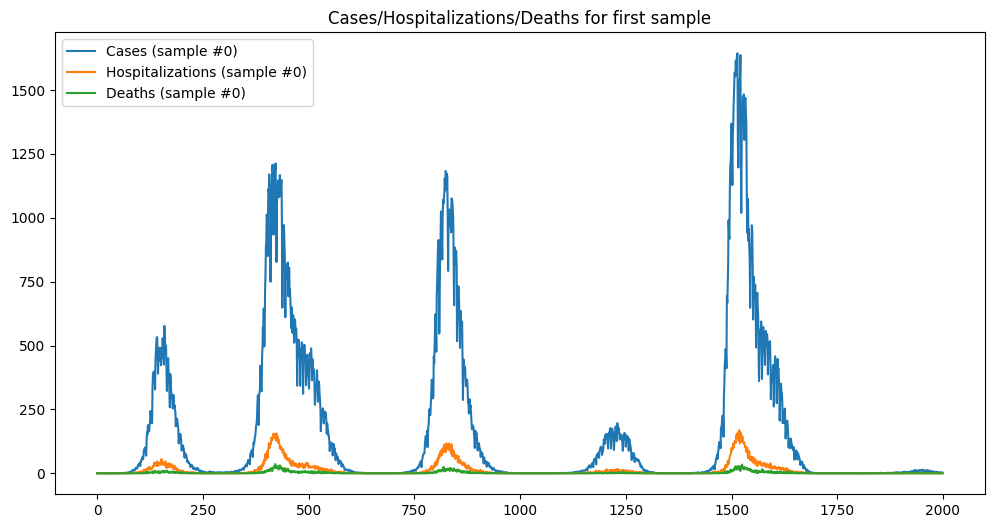


>>> Successfully saved 10000 samples to:
    /content/drive/My Drive/disease_datasets/disease_dataset_03.csv
    File size: 262.44 MB

Dataset shape: (10000, 6003)
Columns: ['cases_day_0', 'hosp_day_0', 'death_day_0', 'cases_day_1', 'hosp_day_1', 'death_day_1', 'cases_day_2', 'hosp_day_2', 'death_day_2', 'cases_day_3', 'hosp_day_3', 'death_day_3', 'cases_day_4', 'hosp_day_4', 'death_day_4', 'cases_day_5', 'hosp_day_5', 'death_day_5', 'cases_day_6', 'hosp_day_6', 'death_day_6', 'cases_day_7', 'hosp_day_7', 'death_day_7', 'cases_day_8', 'hosp_day_8', 'death_day_8', 'cases_day_9', 'hosp_day_9', 'death_day_9', 'cases_day_10', 'hosp_day_10', 'death_day_10', 'cases_day_11', 'hosp_day_11', 'death_day_11', 'cases_day_12', 'hosp_day_12', 'death_day_12', 'cases_day_13', 'hosp_day_13', 'death_day_13', 'cases_day_14', 'hosp_day_14', 'death_day_14', 'cases_day_15', 'hosp_day_15', 'death_day_15', 'cases_day_16', 'hosp_day_16', 'death_day_16', 'cases_day_17', 'hosp_day_17', 'death_day_17', 'cases_da

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
from pathlib import Path
import time
from google.colab import drive
import matplotlib.pyplot as plt


def generate_complete_disease_dataset(
    num_samples=10_000,
    seq_length=2000,
    num_workers=4,
    batch_size=2,
    seed=None,
    output_filename='complete_disease_dataset.csv'
):
    """
    Generate a comprehensive dataset that includes daily new cases, hospitalizations, and deaths.
    We create a DataFrame with:
      - 'cases_day_<i>'
      - 'hosp_day_<i>'
      - 'death_day_<i>'
      - population, disease characteristics, is_waterborne, is_vectorborne

    This matches the format produced by generate_and_save_disease_dataset_01().
    """

    if seed is None:
        seed = int(time.time())

    # Mount Google Drive
    drive.mount('/content/drive')

    # Instantiate the dataset
    dataset = DiseaseSimulationDataset(
        num_samples=num_samples,
        seed=seed,
        num_workers=num_workers,
        batch_size=batch_size
    )

    # Lists to hold data
    all_cases = []
    all_hosp = []
    all_death = []
    all_pop = []
    all_chars = []

    def pad_or_truncate(data_tensor):
        # Convert to numpy
        arr = data_tensor.numpy()
        # Pad or truncate to seq_length
        if len(arr) < seq_length:
            return np.pad(arr, (0, seq_length - len(arr)))
        return arr[:seq_length]

    print("\nCollecting cases, hospitalizations & deaths from dataset...")

    # Loop over all samples
    # The dataset item format is:
    # (true_cases, reported_cases,
    #  hosp_true_t, hosp_rep_t,
    #  death_true_t, death_rep_t,
    #  sim_type, gen_params, disease_chars)
    for (true_cases, reported_cases,
         hosp_true_t, hosp_rep_t,
         death_true_t, death_rep_t,
         sim_type, gen_params, disease_chars) in tqdm(dataset, desc="Processing samples"):

        # We'll use reported values here (not true values)
        cases_rep = pad_or_truncate(reported_cases)
        hosp_rep = pad_or_truncate(hosp_rep_t)
        death_rep = pad_or_truncate(death_rep_t)

        # Obtain population
        if sim_type == 'vector':
            population = gen_params['simulation']['human_population']
        else:
            population = gen_params['simulation']['population_size']

        all_cases.append(cases_rep)
        all_hosp.append(hosp_rep)
        all_death.append(death_rep)
        all_pop.append(population)
        all_chars.append(disease_chars.numpy())

    # Convert lists to arrays
    cases_array = np.stack(all_cases)   # shape: (num_samples, seq_length)
    hosp_array = np.stack(all_hosp)     # shape: (num_samples, seq_length)
    death_array = np.stack(all_death)   # shape: (num_samples, seq_length)
    chars_array = np.stack(all_chars)

    # Optional: quick visualization of the first sample
    plt.figure(figsize=(12, 6))
    plt.plot(cases_array[0], label="Cases (sample #0)")
    plt.plot(hosp_array[0], label="Hospitalizations (sample #0)")
    plt.plot(death_array[0], label="Deaths (sample #0)")
    plt.title("Cases/Hospitalizations/Deaths for first sample")
    plt.legend()
    plt.show()

    # Build DataFrame
    df_dict = {}

    # For each day, create columns for cases, hospitalizations, and deaths
    for i in range(seq_length):
        df_dict[f"cases_day_{i}"] = cases_array[:, i]
        df_dict[f"hosp_day_{i}"] = hosp_array[:, i]
        df_dict[f"death_day_{i}"] = death_array[:, i]

    # Add population and other characteristics
    df_dict.update({
        'population': all_pop,
        'is_waterborne': np.zeros(len(all_pop)),  # Set to 0 as in the original function
        'is_vectorborne': np.zeros(len(all_pop))  # Set to 0 as in the original function
    })

    # Create DataFrame
    df = pd.DataFrame(df_dict)

    # Save to CSV in the same Google Drive folder
    drive_path = "/content/drive/My Drive/disease_datasets"
    Path(drive_path).mkdir(parents=True, exist_ok=True)

    output_path = Path(drive_path) / output_filename
    df.to_csv(output_path, index=False)

    print(f"\n>>> Successfully saved {len(df)} samples to:")
    print(f"    {output_path}")
    size_mb = output_path.stat().st_size / (1024*1024)
    print(f"    File size: {size_mb:.2f} MB")

    return df


# Example usage:
if __name__ == "__main__":
    df = generate_complete_disease_dataset(
        num_samples=10000,
        seq_length=2000,
        num_workers=4,
        batch_size=2,
        output_filename='disease_dataset_03.csv'
    )

    print(f"\nDataset shape: {df.shape}")
    print("Columns:", list(df.columns))

Mounted at /content/drive
Generating hospital/death dataset...


Generating Disease Simulations:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing samples:   0%|          | 0/5000 [00:00<?, ?it/s]

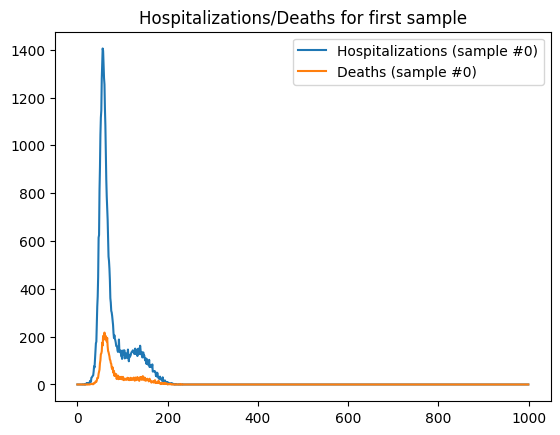


Dataset shape: (5000, 2010)
Columns: ['hosp_day_0', 'death_day_0', 'hosp_day_1', 'death_day_1', 'hosp_day_2', 'death_day_2', 'hosp_day_3', 'death_day_3', 'hosp_day_4', 'death_day_4', 'hosp_day_5', 'death_day_5', 'hosp_day_6', 'death_day_6', 'hosp_day_7', 'death_day_7', 'hosp_day_8', 'death_day_8', 'hosp_day_9', 'death_day_9', 'hosp_day_10', 'death_day_10', 'hosp_day_11', 'death_day_11', 'hosp_day_12', 'death_day_12', 'hosp_day_13', 'death_day_13', 'hosp_day_14', 'death_day_14', 'hosp_day_15', 'death_day_15', 'hosp_day_16', 'death_day_16', 'hosp_day_17', 'death_day_17', 'hosp_day_18', 'death_day_18', 'hosp_day_19', 'death_day_19', 'hosp_day_20', 'death_day_20', 'hosp_day_21', 'death_day_21', 'hosp_day_22', 'death_day_22', 'hosp_day_23', 'death_day_23', 'hosp_day_24', 'death_day_24', 'hosp_day_25', 'death_day_25', 'hosp_day_26', 'death_day_26', 'hosp_day_27', 'death_day_27', 'hosp_day_28', 'death_day_28', 'hosp_day_29', 'death_day_29', 'hosp_day_30', 'death_day_30', 'hosp_day_31', 'deat

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
from pathlib import Path
import time
from google.colab import drive
import matplotlib.pyplot as plt



def generate_dataset_with_hosp_and_deaths(num_samples=10_000,
                                          seq_length=1000,
                                          num_workers=4,
                                          batch_size=2,
                                          seed=None):
    """
    Generate dataset that includes ONLY hospitalizations and deaths (not daily new cases).
    We create a DataFrame with:
      - 'hosp_day_<i>'
      - 'death_day_<i>'
      - population, simulator_type, disease characteristics
    """

    if seed is None:
        seed = int(time.time())

    # Instantiate the dataset
    dataset = DiseaseSimulationDataset(
        num_samples=num_samples,
        seed=seed,
        num_workers=num_workers,
        batch_size=batch_size
    )

    # Lists to hold data
    all_hosp = []
    all_death = []
    all_pop = []
    all_sim_types = []
    all_chars = []

    def pad_or_truncate(data_tensor):
        # Convert to numpy
        arr = data_tensor.numpy()
        # Pad or truncate to seq_length
        if len(arr) < seq_length:
            return np.pad(arr, (0, seq_length - len(arr)))
        return arr[:seq_length]

    print("\nCollecting hospitalizations & deaths from dataset...")

    # Loop over all samples
    # The extended dataset item is:
    # (true_cases, reported_cases,
    #  hosp_true_t, hosp_rep_t,
    #  death_true_t, death_rep_t,
    #  sim_type, gen_params, disease_chars)
    for (true_cases, reported_cases,
         hosp_true_t, hosp_rep_t,
         death_true_t, death_rep_t,
         sim_type, gen_params, disease_chars) in tqdm(dataset, desc="Processing samples"):

        # We'll use reported hospitalizations & deaths here
        hosp_rep = pad_or_truncate(hosp_rep_t)
        death_rep = pad_or_truncate(death_rep_t)

        # Obtain population
        if sim_type == 'vector':
            population = gen_params['simulation']['human_population']
        else:
            population = gen_params['simulation']['population_size']

        all_hosp.append(hosp_rep)
        all_death.append(death_rep)
        all_pop.append(population)
        all_sim_types.append(sim_type)
        all_chars.append(disease_chars.numpy())

    # Convert lists to arrays
    hosp_array = np.stack(all_hosp)   # shape: (num_samples, seq_length)
    death_array = np.stack(all_death) # shape: (num_samples, seq_length)
    chars_array = np.stack(all_chars)

    # Optional: quick visualization of the first sample's hospitalizations or deaths
    # (comment out if not desired)
    plt.figure()
    plt.plot(hosp_array[0], label="Hospitalizations (sample #0)")
    plt.plot(death_array[0], label="Deaths (sample #0)")
    plt.title("Hospitalizations/Deaths for first sample")
    plt.legend()
    plt.show()

    # Build DataFrame
    df_dict = {}

    # For each day, create a column for hospitalizations + one for deaths
    for i in range(seq_length):
        df_dict[f"hosp_day_{i}"] = hosp_array[:, i]
        df_dict[f"death_day_{i}"] = death_array[:, i]

    # Add disease characteristics & population
    df_dict.update({
        'population': all_pop,
        'simulator_type': all_sim_types,
        'is_waterborne': chars_array[:, 0],
        'is_vectorborne': chars_array[:, 1],
        'has_latent_period': chars_array[:, 2],
        'has_waning_immunity': chars_array[:, 3],
        'has_seasonality': chars_array[:, 4],
        'has_asymptomatic': chars_array[:, 5],
        'has_intervention': chars_array[:, 6],
        'has_underreporting': chars_array[:, 7]
    })

    df = pd.DataFrame(df_dict)

    return df

def save_dataset(df, output_filename='disease_dataset_with_hosp_death.csv'):
    """Save DataFrame to csv file in Google Drive."""
    drive_path = "/content/drive/My Drive/disease_datasets"  # Adjust if needed
    Path(drive_path).mkdir(parents=True, exist_ok=True)

    output_path = Path(drive_path) / output_filename
    df.to_csv(output_path, index=False)

    print(f"Dataset saved to {output_path}")
    print(f"File size: {output_path.stat().st_size / (1024*1024):.2f} MB")

# Example usage (if run as a script):
if __name__ == "__main__":

    # Mount Google Drive
    drive.mount('/content/drive')

    # Generate & store
    print("Generating hospital/death dataset...")
    df = generate_dataset_with_hosp_and_deaths(
        num_samples=7500,
        seq_length=2000,
        num_workers=94,
        batch_size=2,
        seed=None
    )

    print(f"\nDataset shape: {df.shape}")
    print("Columns:", list(df.columns))

    # Show a summary
    print("\nData summary:")
    print(df.describe(include='all'))

    # Example distribution checks
    print("\nSimulator type distribution:")
    print(df['simulator_type'].value_counts())

    print("\nDisease characteristics distribution:")
    for col in ['is_waterborne', 'is_vectorborne',
                'has_latent_period', 'has_waning_immunity',
                'has_seasonality', 'has_asymptomatic',
                'has_intervention', 'has_underreporting']:
        print(f"{col}:\n", df[col].value_counts(normalize=True))

    # Save
    save_dataset(df, "flu_pretraining_dataset_08.csv")

In [ ]:
df.head()

,cases_day_0,rt_day_0,cases_day_1,rt_day_1,cases_day_2,rt_day_2,cases_day_3,rt_day_3,cases_day_4,rt_day_4,...,rt_day_999,R0,population,simulator_type,is_waterborne,is_vectorborne,has_latent_period,has_waning_immunity,has_seasonality,has_asymptomatic
0,0.0,0.865372,7.0,0.870257,4.0,0.881885,5.0,0.893938,3.0,0.87389,...,0.0,1.6651,232573,human,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
import psutil
import multiprocessing

def get_optimal_workers():
    # Get number of CPU cores
    physical_cores = psutil.cpu_count(logical=False)  # Physical cores only
    logical_cores = psutil.cpu_count(logical=True)    # Including hyperthreading

    # Get current CPU usage
    cpu_percent = psutil.cpu_percent(interval=1)

    # Get available memory
    memory = psutil.virtual_memory()
    available_memory_gb = memory.available / (1024 ** 3)  # Convert to GB

    print(f"System Information:")
    print(f"Physical CPU cores: {physical_cores}")
    print(f"Logical CPU cores: {logical_cores}")
    print(f"Current CPU usage: {cpu_percent}%")
    print(f"Available memory: {available_memory_gb:.1f} GB")

    # Recommend slightly fewer workers than logical cores
    # to leave some resources for the system
    recommended_workers = max(1, logical_cores - 2)

    print(f"\nRecommended number of workers: {recommended_workers}")

    return recommended_workers

# Use it like this:
num_workers = get_optimal_workers()
print(num_workers)

System Information:
Physical CPU cores: 12
Logical CPU cores: 24
Current CPU usage: 3.6%
Available memory: 45.1 GB

Recommended number of workers: 22
22


In [ ]:
import time

def test_batch_sizes():
    sizes_to_test = [40, 60, 90]
    results = {}

    for batch_size in sizes_to_test:
        start_time = time.time()

        dataset = DiseaseSimulationDataset(
            num_samples=32,
            seed=42,
            num_workers=batch_size,
            batch_size=2
        )

        duration = time.time() - start_time
        memory = psutil.Process().memory_info().rss / 1024 / 1024

        results[batch_size] = {
            'time': duration,
            'memory': memory
        }

        print(f"\nBatch size: {batch_size}")
        print(f"Time: {duration:.2f}s")
        print(f"Memory: {memory:.2f} MB")

    return results

test_batch_sizes()

Generating samples (attempt 1):   0%|          | 0/32 [00:00<?, ?it/s]

Generated 32/32 samples (100.0%)

Batch size: 40
Time: 24.72s
Memory: 359.52 MB


Generating samples (attempt 1):   0%|          | 0/32 [00:00<?, ?it/s]

Generated 32/32 samples (100.0%)

Batch size: 60
Time: 24.72s
Memory: 359.89 MB


Generating samples (attempt 1):   0%|          | 0/32 [00:00<?, ?it/s]

Generated 32/32 samples (100.0%)

Batch size: 90
Time: 22.24s
Memory: 360.13 MB


{40: {'time': 24.721538066864014, 'memory': 359.515625},
 60: {'time': 24.718852996826172, 'memory': 359.890625},
 90: {'time': 22.241397857666016, 'memory': 360.1328125}}